In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os
from cods.od.utils import (
    match_predictions_to_true_boxes,
    generalized_iou,
    assymetric_hausdorff_distance_old,
)
import numpy as np
from cods.od.loss import (
    ODBinaryClassificationLoss,
    ClassificationLossWrapper,
    PixelWiseRecallLoss,
)
import torch
import matplotlib.pyplot as plt


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


In [4]:
def build_preds(model):
    preds_cal = model.build_predictions(
        data_cal,
        dataset_name="mscoco",
        split_name="cal",
        batch_size=12,
        collate_fn=data._collate_fn,  # TODO: make this a default for COCO
        shuffle=False,
        force_recompute=False,  # False,
        deletion_method="nms",
    )
    preds_val = model.build_predictions(
        data_val,
        dataset_name="mscoco",
        split_name="test",
        batch_size=12,
        collate_fn=data._collate_fn,
        shuffle=False,
        force_recompute=False,  # False,
        deletion_method="nms",
    )
    return preds_cal, preds_val

In [5]:
# Filter the preds_cal and preds_val with confidence below 0.001

def filter_preds(preds, confidence_threshold=0.001):
    filters = [
        conf > confidence_threshold
        if (conf > confidence_threshold).any()
        else conf.argmin(0)[None]
        for conf in preds.confidences
    ]
    preds.pred_boxes = [pbs[f] for pbs, f in zip(preds.pred_boxes, filters)]
    preds.pred_cls = [pcs[f] for pcs, f in zip(preds.pred_cls, filters)]
    preds.confidences = [
        conf[f] for conf, f in zip(preds.confidences, filters)
    ]
    return preds



In [6]:
def compute_curves(preds_cal):
    # Measure, for several distance function, the average distance in the match
    loss_cls = ClassificationLossWrapper(ODBinaryClassificationLoss())
    loss_loc = PixelWiseRecallLoss()
    results = {}
    thresholds = np.linspace(0, 0.95, 50)
    FUNCTIONS = {
        "giou": generalized_iou,
        "hausdorff": assymetric_hausdorff_distance_old,
        "lac": lambda x,y: 1,
        "mix": assymetric_hausdorff_distance_old
    }
    for matching_function in ["lac", "hausdorff", "mix"]:#["hausdorff", "giou"]:
        did_first_k = False
        for k_top in [1,2,5,10,20,40]:#for class_factor in [0]:#[0, 1, 5, 25]:
            class_factor = k_top
            key = f"{matching_function}-{class_factor}"  # {'class_factor' if class_factor else ''}"
            key_loc = f"{key}-loc"
            key_cls = f"{key}-cls"
            key_cls_rank = f"{key}-rankmean"
            key_cls_rank95 = f"{key}-rank95"
            key_cls_rank97 = f"{key}-rank97"
            results[key] = []
            results[key_loc] = []
            results[key_cls] = []
            if not did_first_k:
                results[key_cls_rank] = []
                results[key_cls_rank95] = []
                results[key_cls_rank97] = []
            curr_func = FUNCTIONS[matching_function]
            for conf_thr in thresholds:
                match_predictions_to_true_boxes(
                    preds_cal,
                    distance_function=matching_function,
                    overload_confidence_threshold=conf_thr,
                    #class_factor=class_factor,
                )
                distances = []
                dist_cls = []
                dist_loc = []
                rank_cls = []
                rank95_cls = []
                rank97_cls = []
                for i in range(len(preds_cal)):
                    true_boxs = preds_cal.true_boxes[i]
                    true_clss = preds_cal.true_cls[i]
                    pred_boxs = preds_cal.pred_boxes[i]
                    pred_clss = preds_cal.pred_cls[i]
                    matching = preds_cal.matching[i]
                    if len(matching) == 0 or len(matching[0]) == 0:
                        continue
                    try:
                        pred_boxs = torch.stack(
                            [pred_boxs[match_idx[0]] for match_idx in matching]
                        )  # if (len(preds_cal.matching[i]) > 0) or (np.array(list([len(x)>0 for x in preds_cal.matching[i]]))).sum() else []
                    except:
                        print(matching)
                        break
                    pred_clss = torch.stack(
                        [pred_clss[match_idx[0]] for match_idx in matching]
                    )
                    conf_boxs = pred_boxs
                    conf_clss = list([torch.topk(pcls, k_top, dim=0)[1] for pcls in pred_clss])
                    if not did_first_k:
                        sorted_indices = torch.argsort(pred_clss, descending=True, dim=1)
                        ranks = (sorted_indices == true_clss.unsqueeze(1)).nonzero(as_tuple=True)[1]
                        # Correction because rank starts at 1 not 0
                        ranks += 1
                        # print(ranks)
                        # print(ranks.float())
                        # break
                        #rank_cls_val = torch.mean(ranks.float()).item()
                        rank_cls_val = ranks.float().mean().item()#.detach().cpu().numpy() # ADDED MEAN
                        rank_cls.append(rank_cls_val)
                    loss_cls_val = loss_cls(
                        true_boxs, true_clss, conf_boxs, conf_clss
                    )
                    loss_loc_val = loss_loc(
                        true_boxs, true_clss, conf_boxs, conf_clss
                    )
                    dist_cls.append(loss_cls_val)
                    dist_loc.append(loss_loc_val)

                    for j in range(len(true_boxs)):
                        if len(preds_cal.matching[i][j]) == 0:
                            continue
                        match_idx = preds_cal.matching[i][j][0]
                        # try:
                        #     match_idx = preds_cal.matching[i][j][0]
                        # except:
                        #     print(preds_cal.matching[i])
                        dist = curr_func(
                            preds_cal.true_boxes[i][j],
                            preds_cal.pred_boxes[i][match_idx],
                        )

                        # Compute classification and localization loss

                        distances.append(dist)
                results[key].append(np.mean(distances))
                results[key_cls].append(np.mean(dist_cls))
                results[key_loc].append(np.mean(dist_loc))
                if not did_first_k:
                    #rank_cls = np.concatenate(rank_cls)
                    results[key_cls_rank].append(np.mean(rank_cls))
                    results[key_cls_rank95].append(np.percentile(rank_cls, 95))
                    results[key_cls_rank97].append(np.percentile(rank_cls, 97))
            did_first_k = True
    results["thresholds"] = thresholds
    return results

In [7]:
def build_plots(models):
    for model in models:
        preds_cal, preds_val = build_preds(model)  
        preds_cal = filter_preds(preds_cal)
        preds_val = filter_preds(preds_val)
        results = compute_curves(preds_cal)
        
        # four subplots
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
        
        thresholds = results["thresholds"]
        
        # Ax 1 : Distance
        for k, v in results.items():
            if "giou" in k:
                v = 1 - np.array(v)
            if len(k.split("-")) == 2:
                v = np.array(v)
                v /= v.max()
                axs[0].plot(thresholds, v, label=k)
            axs[0].legend()
            axs[0].set_title("Distance")
            axs[0].set_xlabel("Confidence threshold")
            axs[0].set_xticks(np.arange(0, 1, 0.05))
            axs[0].set_ylabel("Normalized distance" if "giou" in k else "Distance")
        
        # Ax 2 : Localization loss
        for k, v in results.items():
            if "loc" in k:
                v = np.array(v)
                #v /= v.max()
                axs[1].plot(thresholds, v, label=k)
            axs[1].legend()
            axs[1].set_title("Localization loss")
            axs[1].set_xlabel("Confidence threshold")
            axs[1].set_xticks(np.arange(0, 1, 0.05))
            axs[1].set_ylabel("Loss")
            
        # Ax 3 : Classification loss
        for k, v in results.items():
            if "cls" in k:
                v = np.array(v)
                #v /= v.max()
                axs[2].plot(thresholds, v, label=k)
            axs[2].legend()
            axs[2].set_title("Classification loss")
            axs[2].set_xlabel("Confidence threshold")
            axs[2].set_xticks(np.arange(0, 1, 0.05))
            #axs[2].set_yticks(np.arange(0,1,0.05))
            axs[2].set_ylabel("Loss")
        
        # Ax 4 : Classification rank
        for k, v in results.items():
            #print(k, len(v))
            #print(v)
            if "rank" in k:
                v = np.array(v)
                #v /= v.max()
                axs[3].plot(thresholds, v, label=k)
            axs[3].legend()
            axs[3].set_title("Classification rank")
            axs[3].set_xlabel("Confidence threshold")
            axs[3].set_xticks(np.arange(0, 1, 0.05))
            axs[3].set_ylabel("Rank")
            
        #plt.title(f"Model {type(model)}")
        fig.suptitle(f"Model {model.model_name}")
        plt.savefig(f"figs/plot_curves_{model.model_name}.png")
        plt.show()

In [8]:
model_detr50 = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
model_detr101 = DETRModel(model_name="detr_resnet101", pretrained=True, device="cpu")
model_yolov8x = YOLOModel(model_name="yolov8x.pt", pretrained=True, device="cpu")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum o

Predictions already exist, loading them...
Predictions already exist, loading them...


/tmp/ipykernel_3923146/2353927293.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/tmp/ipykernel_3923146/2353927293.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()
/tmp/ipykernel_3923146/2353927293.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[3].legend()


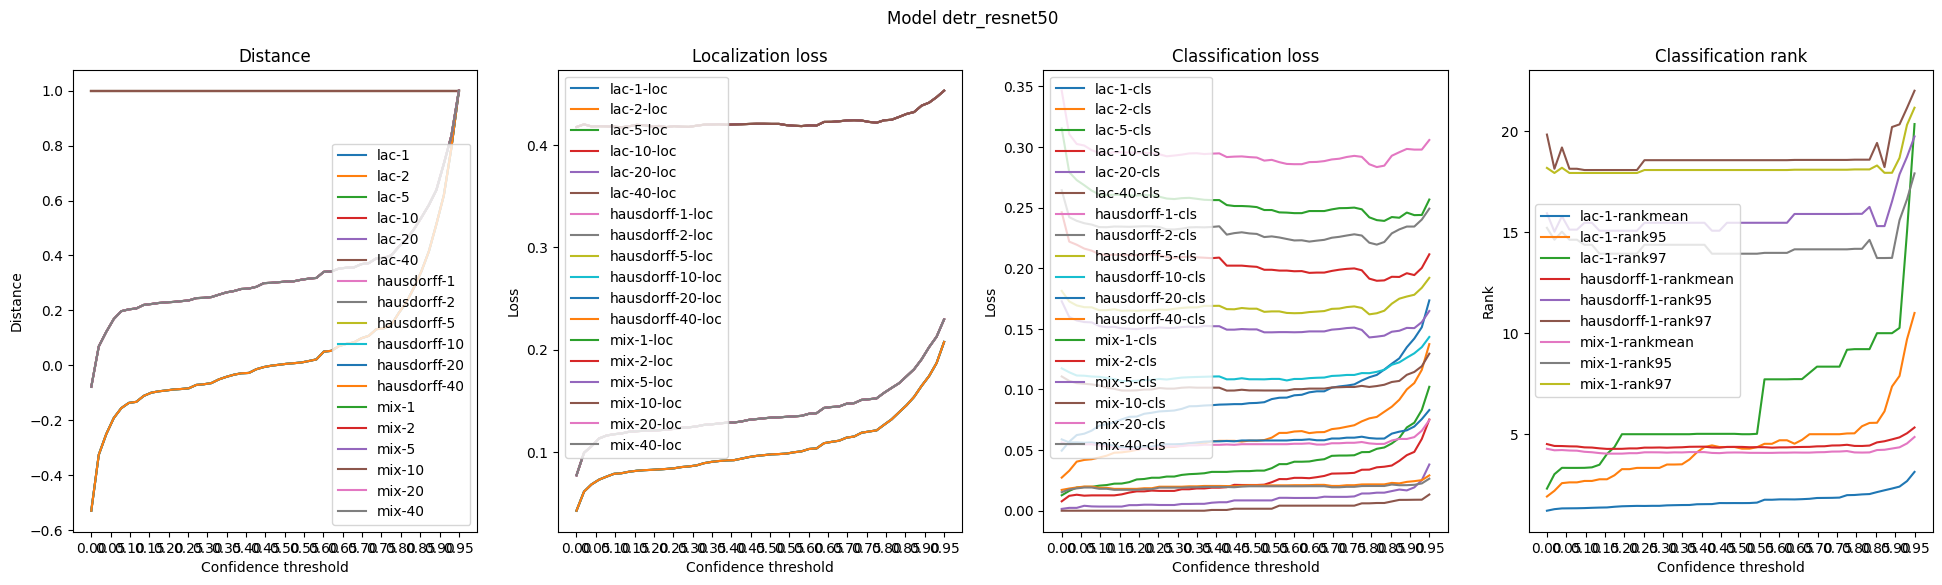

Predictions already exist, loading them...
Predictions already exist, loading them...


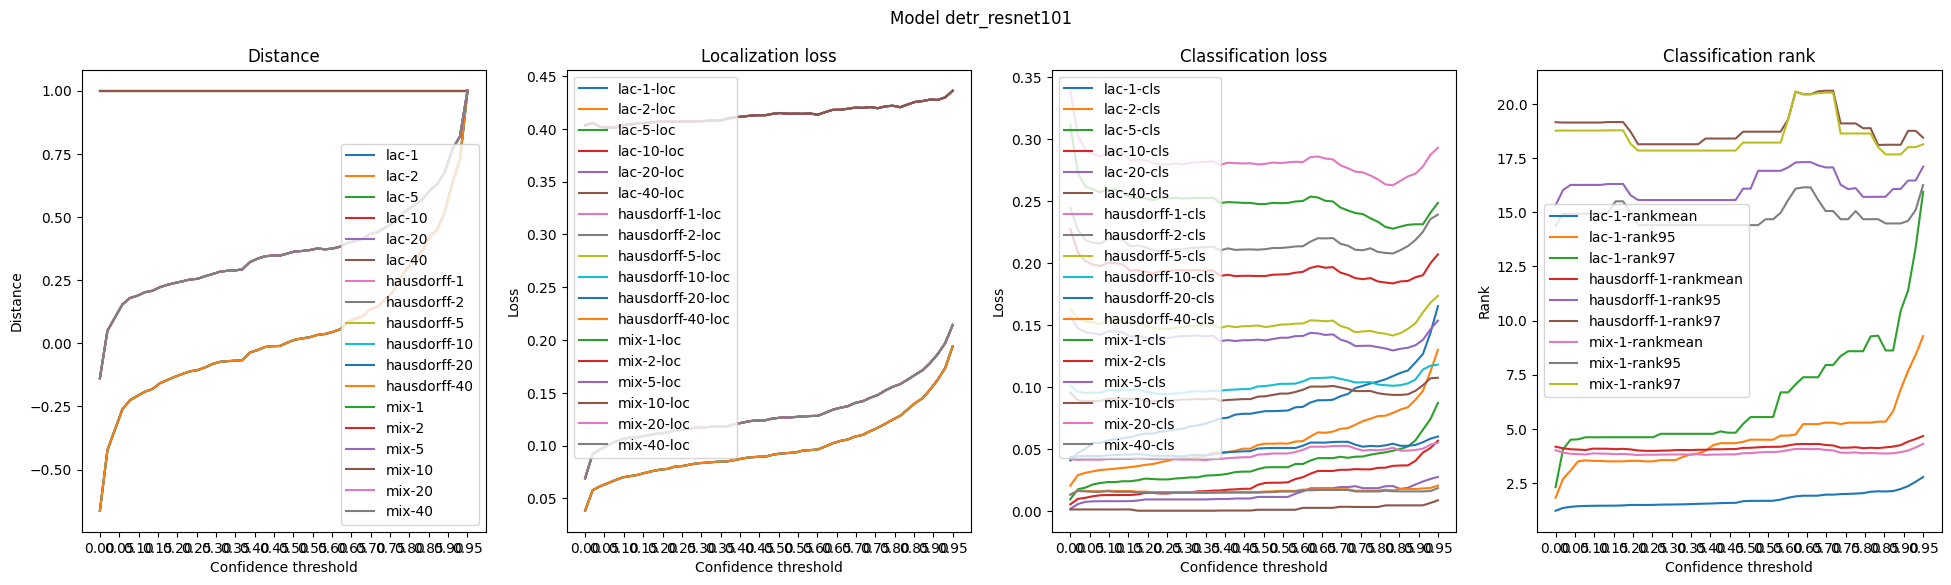

Predictions already exist, loading them...
Predictions already exist, loading them...


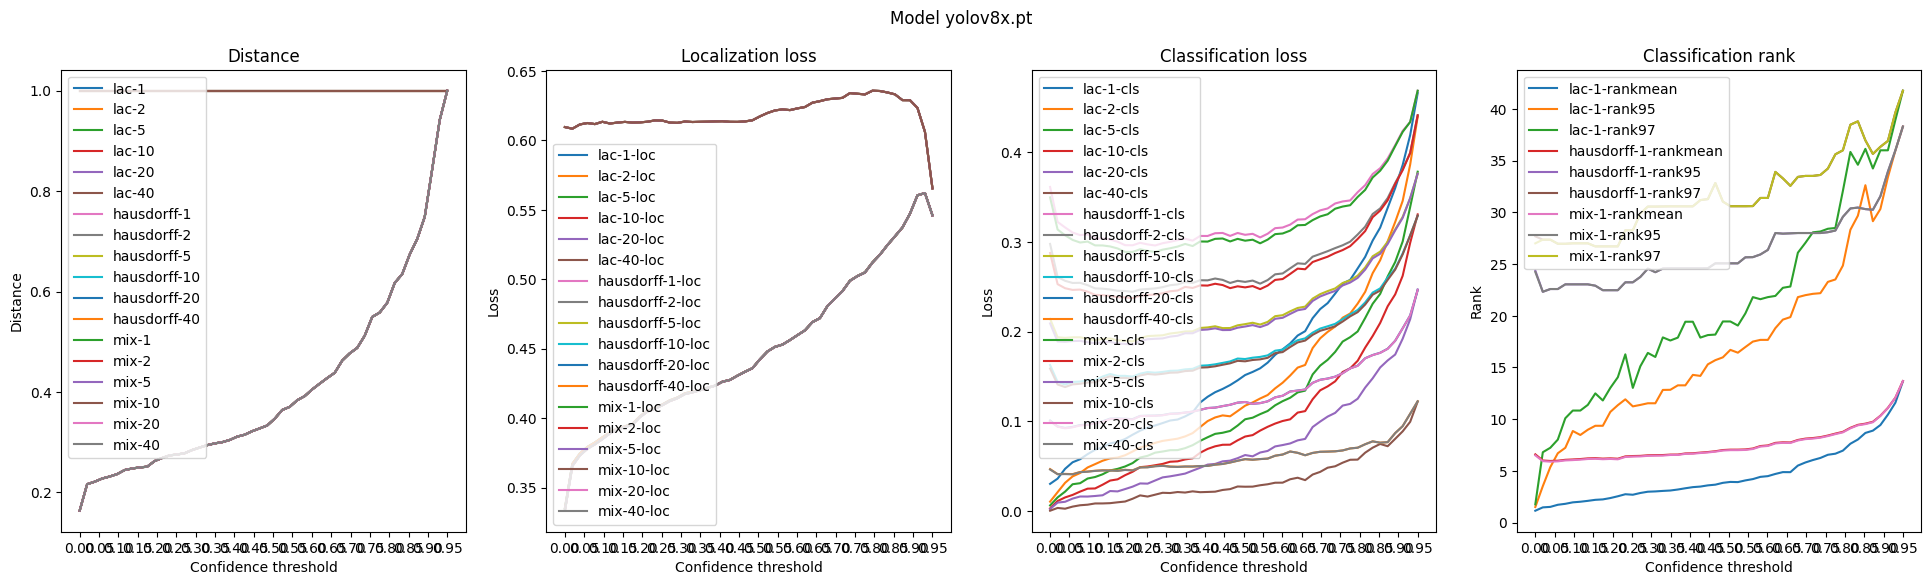

In [9]:
build_plots([model_detr50, model_detr101, model_yolov8x])

comparer à la mean set size pour les prediction sets qui sont couvrants

In [10]:
print(np.diff(results["lac-0-cls"]))
idx = np.where(np.diff(results["lac-0-cls"])<0)[0][0]
print(idx)
print(np.diff(results["lac-0-cls"])[idx]  )
print(results["lac-0-cls"][idx:idx+3])

NameError: name 'results' is not defined

In [ ]:
from cods.od.cp import ODConformalizer

def compute_curves_set_sizes(preds_cal, preds_val, n_thresholds=50):
    results = {}
    thresholds = np.linspace(0, 0.95, n_thresholds)
    for matching_function in ["lac", "hausdorff", "mix"]:#["giou"]:
        for class_factor in [0.5]:
            key = f"{matching_function}-{class_factor}"  
            key_loc = f"{key}-loc"
            key_cls = f"{key}-cls"
            key_cnf = f"{key}-cnf"
            key_loc_95 = f"{key}-loc95"
            key_cls_95 = f"{key}-cls95"
            key_cnf_95 = f"{key}-cnf95"
            key_lbd_loc = f"{key}-lbd_loc"
            key_lbd_cls = f"{key}-lbd_cls"
            results[key] = []
            results[key_loc] = []
            results[key_cls] = []
            results[key_cnf] = []
            results[key_loc_95] = []
            results[key_cls_95] = []
            results[key_cnf_95] = []
            results[key_lbd_loc] = []
            results[key_lbd_cls] = []
            for conf_thr in thresholds:
                conf = ODConformalizer(
                    multiple_testing_correction=None,
                    #confidence_method="box_count_recall",  # "box_thresholded_distance",  # "nb_boxes",
                    confidence_threshold=conf_thr,
                    localization_method="pixelwise",
                    localization_prediction_set="additive",
                    classification_method="binary",
                    classification_prediction_set="lac",
                    backend="auto",
                    optimizer="binary_search",
                    matching_function=matching_function,
                    device="cuda",
                )
                
                parameters = conf.calibrate(
                    preds_cal,
                    #alpha_confidence=0.03,
                    alpha_localization=0.03,
                    alpha_classification=0.07,
                    verbose=False, 
                )
                
                conformal_preds = conf.conformalize(preds_val, parameters=parameters, verbose=False)
                
                results_val = conf.evaluate(
                    preds_val,
                    parameters=parameters,
                    conformalized_predictions=conformal_preds,
                    include_confidence_in_global=False,
                    verbose=False
                )
                
                cls_ss = results_val.classification_set_sizes
                loc_ss = results_val.localization_set_sizes
                #cnf_ss = results_val.confidence_set_sizes
                results[key_cls].append(torch.mean(cls_ss.float()).item())
                results[key_loc].append(torch.mean(loc_ss.float()).item())
                #results[key_cnf].append(torch.mean(cnf_ss.float()).item())
                results[key_cls_95].append(torch.quantile(cls_ss, 0.95).item())
                results[key_loc_95].append(torch.quantile(loc_ss, 0.95).item())
                #results[key_cnf_95].append(torch.quantile(cnf_ss, 0.95).item()) 
                results[key_lbd_cls].append(conf.classification_conformalizer.lambda_classification)
                results[key_lbd_loc].append(conf.localization_conformalizer.lambda_localization)
                
                preds_cal.confidence_threshold = None
                preds_val.confidence_threshold = None
                preds_cal.matching = None
                preds_val.matching = None
    results["thresholds"] = thresholds
    return results

# Relancer les expés pour tous avec pixelwise

In [10]:
model_detr50c = DETRModel(model_name="detr_resnet50", pretrained=True, device="cuda")
model_detr101c = DETRModel(model_name="detr_resnet101", pretrained=True, device="cuda")
model_yolov8xc = YOLOModel(model_name="yolov8x.pt", pretrained=True, device="cuda")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum o

# TODO: plot des lambda cls et lambda loc.
# TODO2 : lambda + et - fonction de n_cal, et/ou fonction de alpha_cal

In [ ]:
import pickle

class_factor = 0.5  
models = [model_detr50c, model_detr101c, model_yolov8xc]

def compute_experiment_results(models, class_factor=0.5):
    res = {}
    for i, model in enumerate(models):
        model_name = model.model_name
        preds_cal, preds_val = build_preds(model)
        preds_cal = filter_preds(preds_cal)
        preds_val = filter_preds(preds_val)
        model_results = compute_curves_set_sizes(preds_cal, preds_val,n_thresholds=6)
        res[model_name] = model_results
        with open('res_dict_new_mix.pkl', 'wb') as f:
            pickle.dump(res, f)
    return res

res = compute_experiment_results(models, class_factor=class_factor)

In [6]:
import pickle

with open('res_dict_new_mix.pkl', 'rb') as f:
    res = pickle.load(f)

In [7]:
import pickle

# Load the old dictionary
with open('res_dict.pkl', 'rb') as f:
    old_res = pickle.load(f)

for k in res.keys():
    # Update the new dictionary with the old dictionary
    old_res[k].update(res[k])

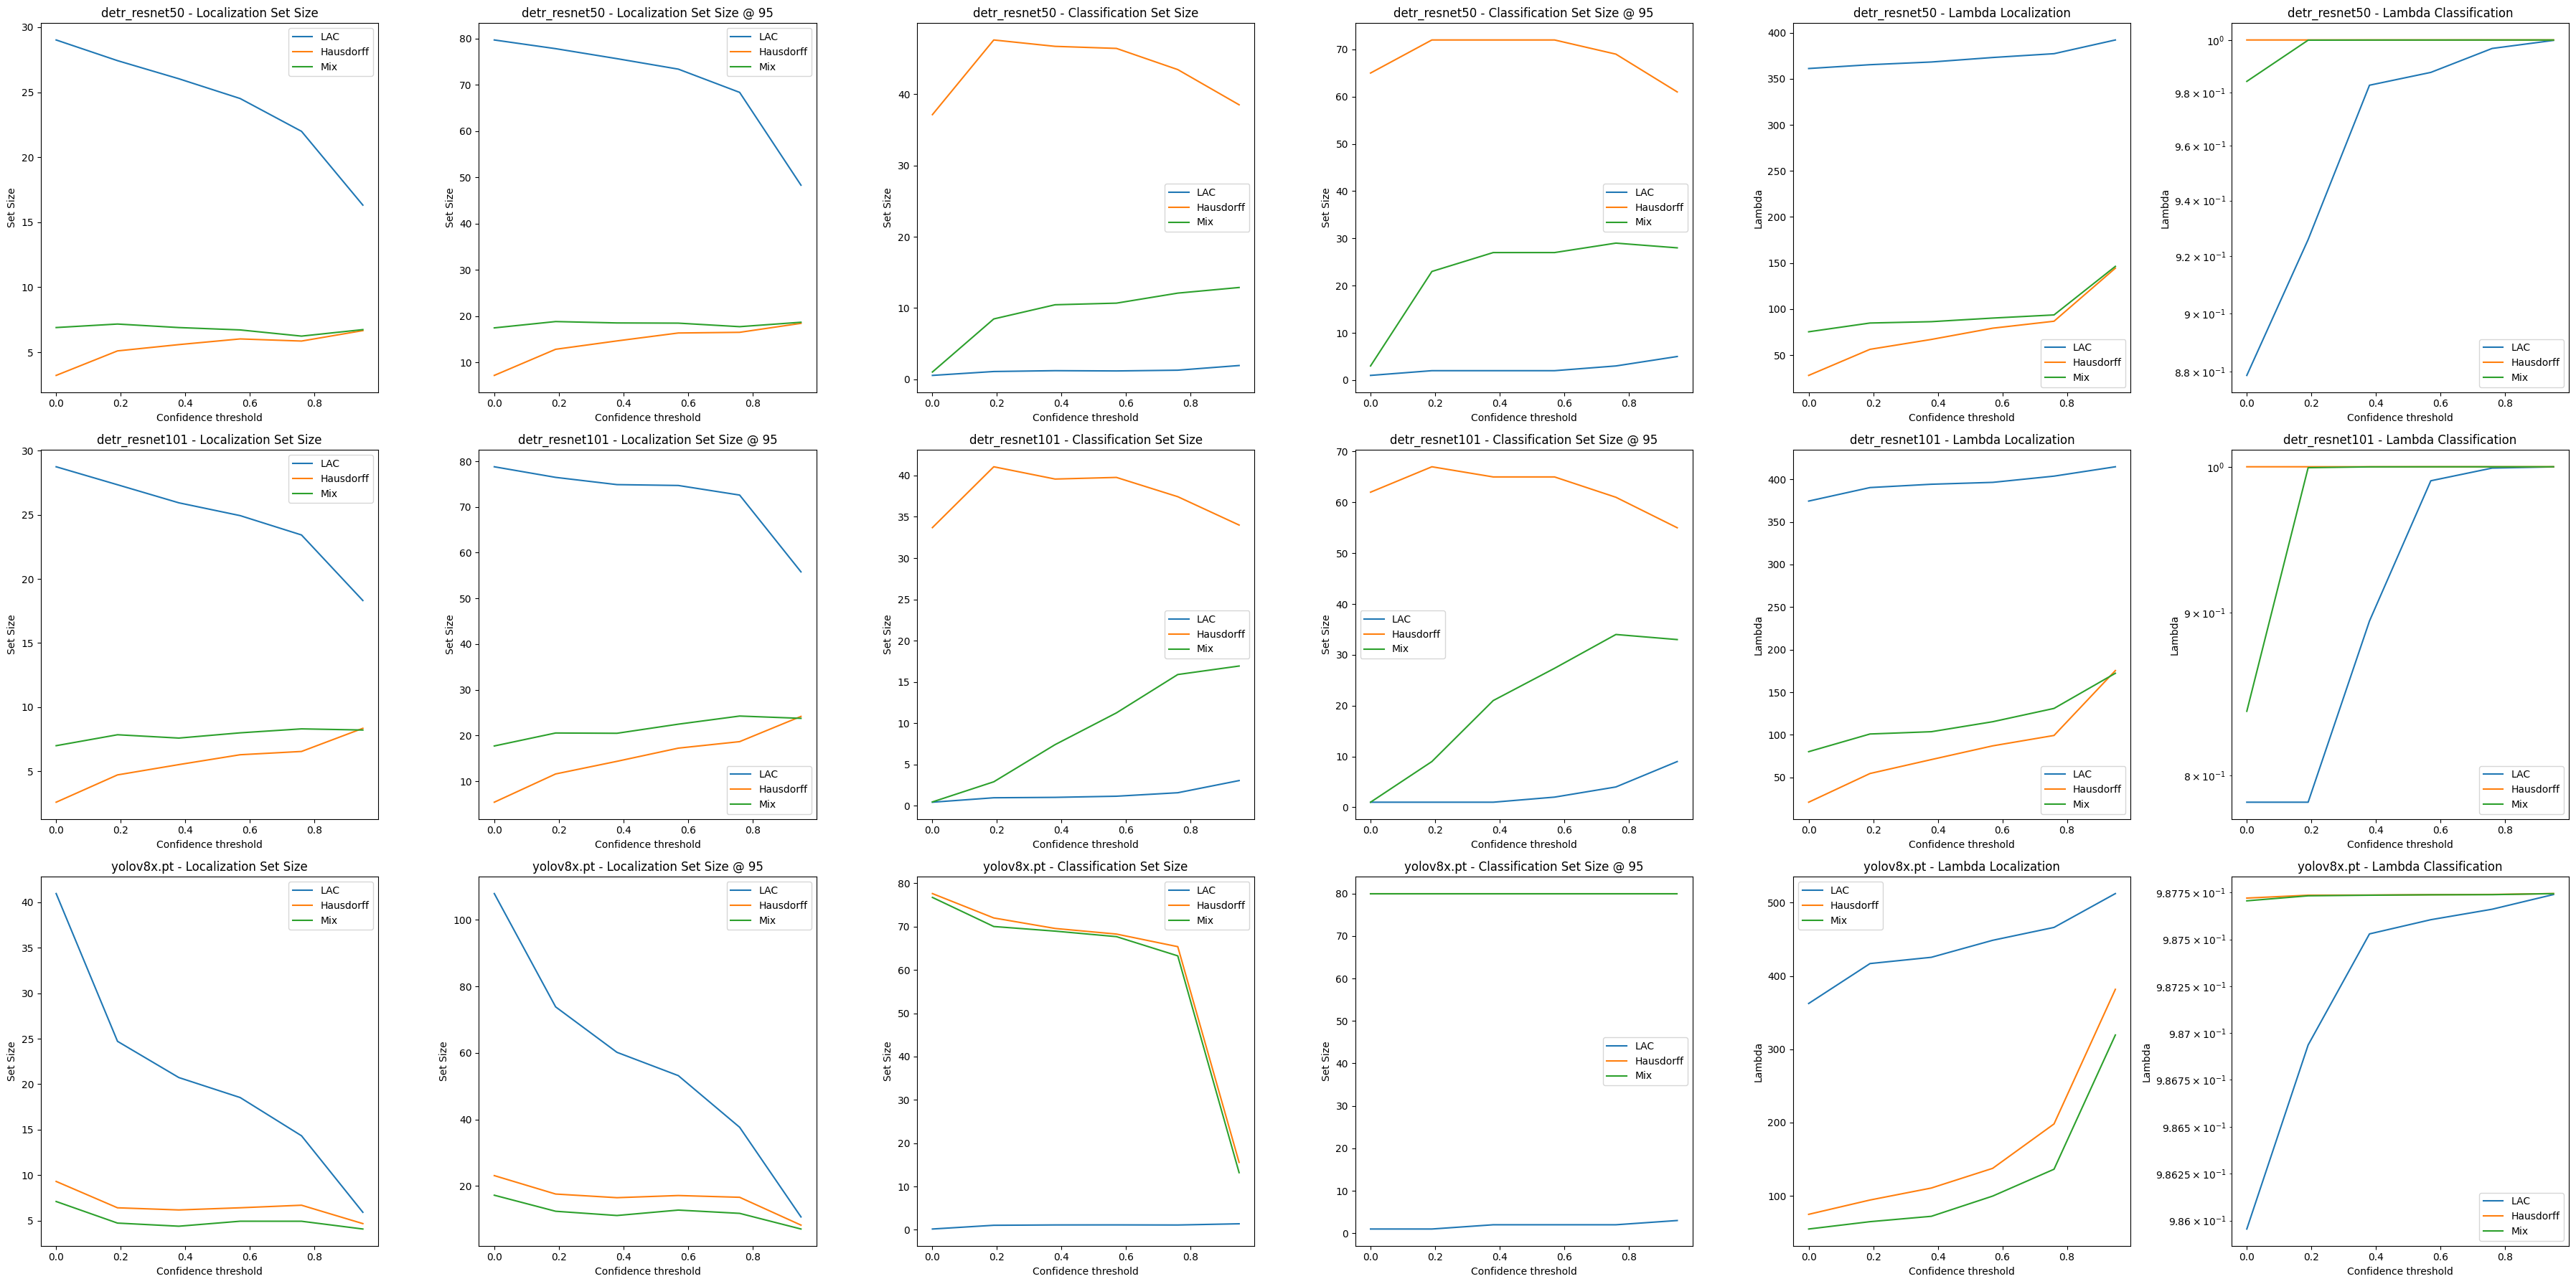

In [13]:
fig, axs = plt.subplots(3, 6, figsize=(36, 18))

res = old_res


for i, model in enumerate(models):
    model_name = model.model_name
    model_results = res[model_name]

    thresholds = model_results["thresholds"]

    # Plot Localization Set Size
    axs[i, 0].plot(thresholds, model_results[f"lac-{class_factor}-loc"], label="LAC")
    axs[i, 0].plot(thresholds, model_results[f"hausdorff-{class_factor}-loc"], label="Hausdorff")
    axs[i, 0].plot(thresholds, model_results[f"mix-{class_factor}-loc"], label="Mix")
    axs[i, 0].set_title(f"{model_name} - Localization Set Size")
    axs[i, 0].set_xlabel("Confidence threshold")
    axs[i, 0].set_ylabel("Set Size")
    axs[i, 0].legend()

    # Plot Localization @ 95 Set Size
    axs[i, 1].plot(thresholds, model_results[f"lac-{class_factor}-loc95"], label="LAC")
    axs[i, 1].plot(thresholds, model_results[f"hausdorff-{class_factor}-loc95"], label="Hausdorff")
    axs[i, 1].plot(thresholds, model_results[f"mix-{class_factor}-loc95"], label="Mix")
    axs[i, 1].set_title(f"{model_name} - Localization Set Size @ 95")
    axs[i, 1].set_xlabel("Confidence threshold")
    axs[i, 1].set_ylabel("Set Size")
    axs[i, 1].legend()

    # Plot Classification Set Size
    axs[i, 2].plot(thresholds, model_results[f"lac-{class_factor}-cls"], label="LAC")
    axs[i, 2].plot(thresholds, model_results[f"hausdorff-{class_factor}-cls"], label="Hausdorff")
    axs[i, 2].plot(thresholds, model_results[f"mix-{class_factor}-cls"], label="Mix")
    axs[i, 2].set_title(f"{model_name} - Classification Set Size")
    axs[i, 2].set_xlabel("Confidence threshold")
    axs[i, 2].set_ylabel("Set Size")
    axs[i, 2].legend()
    
    # Plot Classification @ 95 Set Size
    axs[i, 3].plot(thresholds, model_results[f"lac-{class_factor}-cls95"], label="LAC")
    axs[i, 3].plot(thresholds, model_results[f"hausdorff-{class_factor}-cls95"], label="Hausdorff")
    axs[i, 3].plot(thresholds, model_results[f"mix-{class_factor}-cls95"], label="Mix")
    axs[i, 3].set_title(f"{model_name} - Classification Set Size @ 95")
    axs[i, 3].set_xlabel("Confidence threshold")
    axs[i, 3].set_ylabel("Set Size")
    axs[i, 3].legend()
    
    # Plot Lambda Loc
    axs[i, 4].plot(thresholds, model_results[f"lac-{class_factor}-lbd_loc"], label="LAC")
    axs[i, 4].plot(thresholds, model_results[f"hausdorff-{class_factor}-lbd_loc"], label="Hausdorff")
    axs[i, 4].plot(thresholds, model_results[f"mix-{class_factor}-lbd_loc"], label="Mix")
    axs[i, 4].set_title(f"{model_name} - Lambda Localization")
    axs[i, 4].set_xlabel("Confidence threshold")
    axs[i, 4].set_ylabel("Lambda")
    axs[i, 4].legend()
    
    # Plot Lambda Cls
    axs[i, 5].plot(thresholds, model_results[f"lac-{class_factor}-lbd_cls"], label="LAC")
    axs[i, 5].plot(thresholds, model_results[f"hausdorff-{class_factor}-lbd_cls"], label="Hausdorff")
    axs[i, 5].plot(thresholds, model_results[f"mix-{class_factor}-lbd_cls"], label="Mix")
    axs[i, 5].set_title(f"{model_name} - Lambda Classification")
    axs[i, 5].set_xlabel("Confidence threshold")
    axs[i, 5].set_ylabel("Lambda")
    axs[i, 5].set_yscale("log")
    axs[i, 5].legend()
    
plt.tight_layout()
plt.savefig("figs/experiment_results_pixelwise.png")
plt.show()